In [ ]:
%%bash
set -e
python -m pip install -q --upgrade pip
python -m pip install -q virtualenv
python -m virtualenv -p python3 /content/hs-env

source /content/hs-env/bin/activate
pip install -q --upgrade pip wheel setuptools
# 評估用相依（與主環境脫鉤，避免 TF/numba 衝突）
pip install -q "numpy==2.0.2" "scipy==1.14.1" "scikit-learn==1.5.2" "pandas==2.2.2" "matplotlib==3.8.4"

python - <<'PY'
import sys, numpy, scipy, sklearn, pandas, matplotlib
print("OK venv:", sys.executable)
print("numpy:", numpy.__version__, "| scipy:", scipy.__version__, "| sklearn:", sklearn.__version__)
print("pandas:", pandas.__version__, "| matplotlib:", matplotlib.__version__)
PY

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
created virtual environment CPython3.12.12.final.0-64 in 867ms
  creator CPython3Posix(dest=/content/hs-env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.3
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
OK venv: /content/hs-env/bin/python
numpy: 2.0.2 | scipy: 1.14.1 | sklearn: 1.5.2
pandas: 2.2.2 | matplotlib: 3.8.4


In [ ]:
# 需要 3 個檔：.ex、hub_last.npy、以及 gold JSON（gemini_gold.json 或 user_gold.json）
from google.colab import files
print("請上傳：leuven_rum_nozeroes.ex、hub_last.npy、gemini_gold.json（或 user_gold.json）")
_ = files.upload()

# 若你想用雲端硬碟，改用以下（取消註解、cp 到 /content）：
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "/content/drive/MyDrive/path/to/leuven_rum_nozeroes.ex" /content/
# !cp "/content/drive/MyDrive/path/to/hub_last.npy" /content/
# !cp "/content/drive/MyDrive/path/to/gemini_gold.json" /content/

請上傳：leuven_rum_nozeroes.ex、hub_last.npy、gemini_gold.json（或 user_gold.json）


Saving SimLex-999.txt to SimLex-999.txt


In [ ]:
# 你可改以下參數；GOLD_JSON 留空會自動找 gemini_gold.json -> user_gold.json
EX_PATH   = "leuven_rum_nozeroes.ex"
HUB_NPY   = "hub_last.npy"
GOLD_JSON = ""                 # 自動找
OUT_DIR   = "eval_viz_outputs"
TIE_TOL   = 0.005
SHOW_HEATMAP = True
HEATMAP_MAXN = 351

script = script = script = r"""
# eval_pair_triad_minviz.py — print only accuracies, but save ISO heatmap + triadic acc-by-type + CSVs
import os, re, json, argparse, datetime, shutil
import numpy as np
import pandas as pd
from typing import List, Dict
from sklearn.metrics import pairwise_distances
from sklearn.isotonic import IsotonicRegression

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# --- parse .ex ---
def parse_ex_for_concepts(ex_path: str) -> List[str]:
    name_pat = re.compile(r'name:\s*([^\s]+)', re.I)
    tail_pat = re.compile(r't:\s*([0-9\s]+);', re.I)
    cat_pat  = re.compile(r'^(.*?)[Cc](\d+)$')
    order = []
    with open(ex_path, 'r', encoding='utf-8', errors='ignore') as f:
        for raw in f:
            if 'name:' not in raw or 't:' not in raw: continue
            m1 = name_pat.search(raw); m2 = tail_pat.search(raw)
            if not m1 or not m2: continue
            full = m1.group(1)
            mc = cat_pat.match(full)
            if not mc: continue
            base = mc.group(1)
            if base not in order: order.append(base)
    if not order: raise SystemExit(".ex 中找不到 Ck 類別的 name 條目。")
    return order

# --- build Dpred (0..1) from NxD or square ---
def build_pred_matrix(hub: np.ndarray) -> np.ndarray:
    if hub.ndim != 2:
        raise SystemExit(f"hub_npy 必須是 2D，拿到 {hub.ndim}D")
    if hub.shape[0] == hub.shape[1]:
        M = hub.astype(np.float32)
        if np.allclose(M, M.T, atol=1e-5):
            diag = np.diag(M)
            if np.allclose(diag, 0.0, atol=1e-4):
                D = M.copy()
            elif np.allclose(diag, 1.0, atol=1e-3):
                if M.min() >= -1.0 - 1e-3 and M.max() <= 1.0 + 1e-3:
                    D = (1.0 - M) / 2.0
                else:
                    D = 1.0 - M
            else:
                D = M.copy()
        else:
            D = pairwise_distances(M, metric="cosine") / 2.0
    else:
        D = pairwise_distances(hub, metric="cosine") / 2.0
    np.fill_diagonal(D, 0.0)
    return D.astype(np.float32)

# --- normalize gold pairwise to 0..1 if needed ---
def normalize_pairwise_if_needed(pairwise: Dict[str, float], scale_meta: dict|None) -> Dict[str, float]:
    vals = list(pairwise.values())
    if not vals: return pairwise
    vmin, vmax = float(np.nanmin(vals)), float(np.nanmax(vals))
    if vmin >= -1e-6 and vmax <= 1.0 + 1e-6: return pairwise
    if scale_meta and isinstance(scale_meta, dict):
        mapping = str(scale_meta.get("mapping", "")).lower()
        if "99" in mapping:  # 1..100
            return {k: max(0.0, min(1.0, (float(v)-1.0)/99.0)) for k,v in pairwise.items()}
        if "6" in mapping:   # 1..7
            return {k: max(0.0, min(1.0, (float(v)-1.0)/6.0)) for k,v in pairwise.items()}
    if vmin >= 1.0 and vmax <= 7.0:   return {k: (float(v)-1.0)/6.0 for k,v in pairwise.items()}
    if vmin >= 1.0 and vmax <= 100.0: return {k: (float(v)-1.0)/99.0 for k,v in pairwise.items()}
    raise SystemExit(f"無法辨識 pairwise 標度（min={vmin}, max={vmax}）。請檢查 gold JSON。")

# --- triadic accuracy ---
def triadic_accuracy(triads: list, D: np.ndarray, tie_tol: float) -> float:
    if not triads: return float("nan")
    correct = 0
    for tr in triads:
        t, a, b = int(tr["t"]), int(tr["a"]), int(tr["b"])
        ch = str(tr["choice"]).strip().lower()
        da, db = float(D[t, a]), float(D[t, b])
        if ch == "a": ok = (da <= db)
        elif ch == "b": ok = (db <= da)
        else: ok = (abs(da - db) <= float(tie_tol))
        correct += int(ok)
    return correct / len(triads)

# --- pairwise accuracy via median threshold + tie band ---
def pairwise_accuracy_median(pairwise01: Dict[str, float], D_iso: np.ndarray, tie_tol: float) -> float:
    if not pairwise01: return float("nan")
    gold = []
    pred = []
    for key, g in pairwise01.items():
        i, j = map(int, key.split("_"))
        gold.append(float(g))
        pred.append(float(D_iso[i, j]))
    gold = np.asarray(gold, np.float32)
    pred = np.asarray(pred, np.float32)
    theta = np.median(gold)
    g_state = np.where(gold < theta - tie_tol, -1,
                np.where(gold > theta + tie_tol, +1, 0))
    p_state = np.where(pred < theta - tie_tol, -1,
                np.where(pred > theta + tie_tol, +1, 0))
    return float(np.mean(g_state == p_state))

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--ex", required=True)
    ap.add_argument("--hub_npy", required=True)
    ap.add_argument("--gold_json", default="")
    ap.add_argument("--out_dir", default="eval_viz_outputs")  # 用來存圖/CSV/NPY/ZIP
    ap.add_argument("--tie_tol", type=float, default=0.02)
    ap.add_argument("--heatmap_maxn", type=int, default=351)
    args = ap.parse_args()
    os.makedirs(args.out_dir, exist_ok=True)

    # gold
    gold_path = args.gold_json
    if not gold_path:
        for cand in ["gemini_gold.json", "user_gold.json"]:
            if os.path.exists(cand): gold_path = cand; break
    if not gold_path:
        raise SystemExit("找不到 gold JSON，請用 --gold_json 指定或把檔案放在當前目錄。")

    concepts = parse_ex_for_concepts(args.ex)
    hub = np.load(args.hub_npy).astype(np.float32)
    if hub.shape[0] != len(concepts):
        raise SystemExit(f"hub 向量數 {hub.shape[0]} 與概念數 {len(concepts)} 不一致。")

    with open(gold_path, "r", encoding="utf-8") as f:
        gold = json.load(f)
    if gold.get("concepts") != concepts:
        raise SystemExit("gold_json 的 concepts 與 .ex 不一致；請確保來源相同。")

    pairwise_raw = gold.get("pairwise", {}) or {}
    triads       = gold.get("triads", []) or []
    pairwise01   = normalize_pairwise_if_needed(pairwise_raw, gold.get("scale"))

    # Dpred 原始
    Dpred = build_pred_matrix(hub)

    # Isotonic full（等頻 200 bins），失敗則退回 Dpred
    xs, ys = [], []
    for key, g in pairwise01.items():
        i, j = map(int, key.split("_"))
        xs.append(float(Dpred[i, j])); ys.append(float(g))
    xs = np.asarray(xs, np.float32); ys = np.asarray(ys, np.float32)

    Dcal_full = Dpred.copy()
    try:
        if len(xs) >= 50:
            q = np.linspace(0, 1, 201)
            edges = np.quantile(xs, q); edges = np.unique(edges)
            idx = np.clip(np.searchsorted(edges, xs, side="right") - 1, 0, len(edges)-2)
            bx, by = [], []
            for b in range(len(edges)-1):
                m = (idx == b)
                if np.any(m):
                    bx.append(float(xs[m].mean()))
                    by.append(float(ys[m].mean()))
            bx = np.asarray(bx, np.float32); by = np.asarray(by, np.float32)
            iso_full = IsotonicRegression(y_min=0.0, y_max=1.0, increasing=True, out_of_bounds="clip").fit(bx, by)
            Dcal_full = iso_full.predict(Dpred.ravel()).reshape(Dpred.shape).astype(np.float32)
            np.fill_diagonal(Dcal_full, 0.0)
            mn, mx = float(Dcal_full.min()), float(Dcal_full.max())
            if mx > mn + 1e-12:
                Dcal_full = (Dcal_full - mn) / (mx - mn)
    except Exception:
        Dcal_full = Dpred

    # ----- 存 pairwise ISO CSV -----
    rows = []
    for key, g in pairwise01.items():
        i, j = map(int, key.split("_"))
        iso = float(Dcal_full[i, j])
        rows.append({
            "i": i, "j": j,
            "concept_i": concepts[i], "concept_j": concepts[j],
            "gold_dist01": float(g),
            "iso_dist01": iso,
            "abs_err_iso": float(abs(iso - g)),
        })
    df_pairs_iso = pd.DataFrame(rows)
    pairs_csv = os.path.join(args.out_dir, "pairs_iso.csv")
    df_pairs_iso.to_csv(pairs_csv, index=False)

    # ----- 存 triads CSV + acc by type 圖 -----
    tria_rows = []
    for tr in triads:
        t, a, b = int(tr["t"]), int(tr["a"]), int(tr["b"])
        ch = str(tr["choice"]).strip().lower()
        da, db = float(Dpred[t, a]), float(Dpred[t, b])
        pred_choice = "a" if da <= db else "b"
        correct = (pred_choice == ch) or (ch == "tie" and abs(da - db) <= args.tie_tol)
        tria_rows.append({
            "t": t, "a": a, "b": b,
            "concept_t": concepts[t], "concept_a": concepts[a], "concept_b": concepts[b],
            "gold_choice": ch,
            "pred_choice": pred_choice,
            "correct": bool(correct),
        })
    df_triads = pd.DataFrame(tria_rows)
    triad_csv = os.path.join(args.out_dir, "triads_eval.csv")
    df_triads.to_csv(triad_csv, index=False)
    # if not df_triads.empty:
    #     type_acc = df_triads.groupby("gold_choice")["correct"].mean().reset_index()
    #     plt.figure(figsize=(5,4))
    #     plt.bar(type_acc["gold_choice"], type_acc["correct"])
    #     plt.ylim(0,1); plt.xlabel("Gold choice"); plt.ylabel("Accuracy")
    #     plt.title("Triadic accuracy by type")
    #     plt.tight_layout()
    #     tri_type_png = os.path.join(args.out_dir, "triadic_acc_by_type.png")
    #     plt.savefig(tri_type_png, dpi=150); plt.close()
    # else:
    #     tri_type_png = ""

    # ----- 存 ISO heatmap -----
    subN = min(args.heatmap_maxn, len(concepts))
    plt.figure(figsize=(6,5))
    plt.imshow(Dcal_full[:subN,:subN], vmin=0, vmax=1, interpolation="nearest")
    plt.colorbar(label="iso distance (0..1)")
    plt.title(f"ISO-calibrated distance heatmap (top-left {subN}×{subN})")
    plt.tight_layout()
    iso_png = os.path.join(args.out_dir, "pred_dist_heatmap_iso.png")
    plt.savefig(iso_png, dpi=150); plt.close()

    # 存 NPY & ZIP
    np.save(os.path.join(args.out_dir, "Dpred_iso.npy"), Dcal_full)
    zpath = shutil.make_archive(args.out_dir, "zip", args.out_dir)

    # ----- 計算兩個最終指標並「只印這兩個」 -----
    pair_acc = pairwise_accuracy_median(pairwise01, Dcal_full, tie_tol=float(args.tie_tol))
    tri_acc  = triadic_accuracy(triads, Dpred, tie_tol=float(args.tie_tol))

    # 仍把路徑寫到 stderr，避免干擾 stdout 的兩個數字（有些 runner 會抓第一行）
    import sys
    print(f"[SAVED] pairs_csv={pairs_csv}", file=sys.stderr)
    print(f"[SAVED] triads_csv={triad_csv}", file=sys.stderr)
    print(f"[SAVED] iso_heatmap_png={iso_png}", file=sys.stderr)
    # print(f"[SAVED] triadic_acc_by_type_png={tri_type_png}", file=sys.stderr)
    print(f"[ZIP] {zpath}", file=sys.stderr)

    print(json.dumps({"pairwise_accuracy": pair_acc, "triadic_accuracy": tri_acc}, ensure_ascii=False))

if __name__ == "__main__":
    main()
"""

# 寫入腳本
with open("eval_pair_triad.py", "w", encoding="utf-8") as f:
    f.write(script)

# 準備命令
import os, shlex, subprocess
gold = GOLD_JSON.strip()
if not gold:
    for nm in ["gemini_gold.json", "user_gold.json"]:
        if os.path.exists(nm):
            gold = nm; break

cmd = ["/content/hs-env/bin/python", "eval_pair_triad.py",
       "--ex", EX_PATH,
       "--hub_npy", HUB_NPY,
       "--out_dir", OUT_DIR,
       "--tie_tol", str(TIE_TOL)]
if gold: cmd += ["--gold_json", gold]

print("Running:", " ".join(shlex.quote(c) for c in cmd))
out = subprocess.run(cmd, check=True, capture_output=True, text=True)
print(out.stdout)
print(out.stderr)

Running: /content/hs-env/bin/python eval_pair_triad.py --ex leuven_rum_nozeroes.ex --hub_npy hub_last.npy --out_dir eval_viz_outputs --tie_tol 0.005 --gold_json gemini_gold.json
{"pairwise_accuracy": 0.6909854087547471, "triadic_accuracy": 0.619}

[SAVED] pairs_csv=eval_viz_outputs/pairs_iso.csv
[SAVED] triads_csv=eval_viz_outputs/triads_eval.csv
[SAVED] iso_heatmap_png=eval_viz_outputs/pred_dist_heatmap_iso.png
[ZIP] /content/eval_viz_outputs.zip



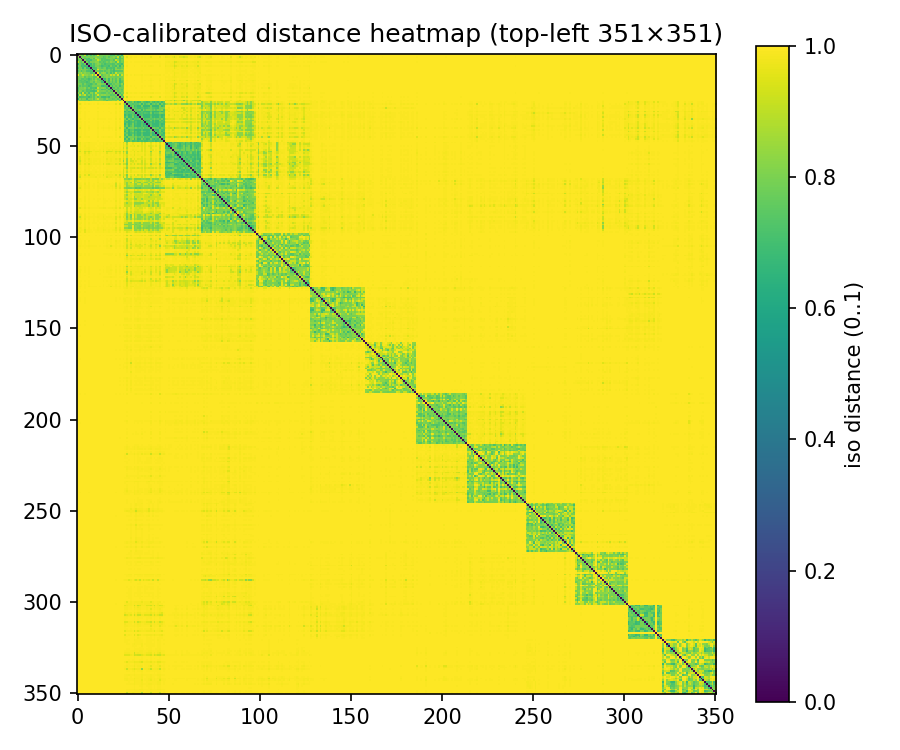

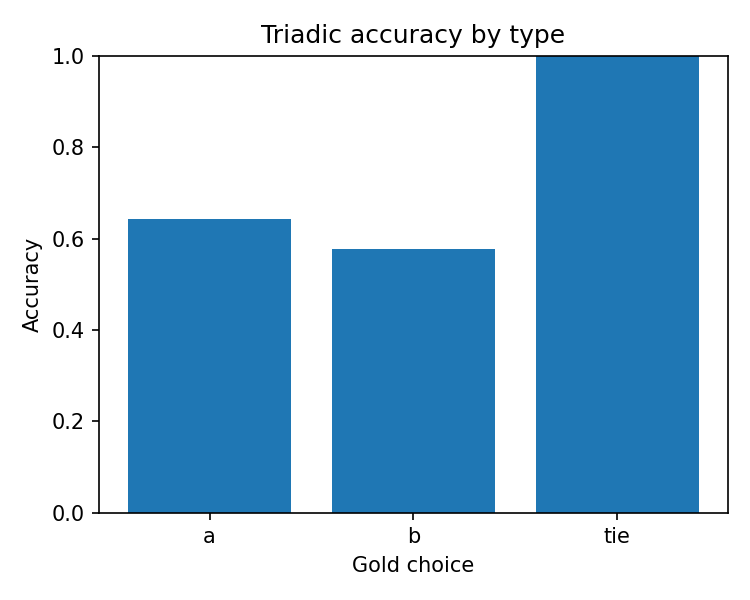

=== pairs_iso.csv ===


,i,j,concept_i,concept_j,gold_dist01,iso_dist01,abs_err_iso
0,226,345,butterknife,tractor,1.000000,0.996183,0.003817
1,100,232,bison,pan,1.000000,0.998543,0.001457
2,199,226,oil_can,butterknife,0.868687,0.987468,0.118781
3,76,80,canary,chickadee,0.686869,0.703784,0.016916
4,18,77,caterpillar,chicken,1.000000,0.997767,0.002233


=== triads_eval.csv ===


,t,a,b,concept_t,concept_a,concept_b,gold_choice,pred_choice,correct
0,192,206,251,hammer,nail,contrabass,a,a,True
1,169,228,251,chervil,mixer,contrabass,a,a,True
2,204,38,222,screwdriver,plaice,kettle,b,b,True
3,222,224,333,kettle,coffee_maker,hovercraft,a,a,True
4,258,102,312,harp_,squirrel,pistol,b,a,False


{"pairwise_accuracy": 0.6909854087547471, "triadic_accuracy": 0.619}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Minimal viewer for ISO pairwise + triadic (fits your new outputs) ===
import os, json, numpy as np, pandas as pd
from IPython.display import Image, display

OUT_DIR = "eval_viz_outputs"
TIE_TOL = 0.005  # 與腳本一致；需要改時這裡一起改

# --- 準備路徑 ---
pairs_csv   = os.path.join(OUT_DIR, "pairs_iso.csv")         # 新版 pairwise CSV
triads_csv  = os.path.join(OUT_DIR, "triads_eval.csv")       # 新版 triads CSV
iso_png     = os.path.join(OUT_DIR, "pred_dist_heatmap_iso.png")
tri_type_png= os.path.join(OUT_DIR, "triadic_acc_by_type.png")
bundle_zip  = OUT_DIR + ".zip"

# --- 計算 pairwise accuracy（median threshold + tie band）---
def compute_pairwise_acc(pairs_csv_path: str, tie_tol: float = 0.02) -> float:
    df = pd.read_csv(pairs_csv_path)
    # 需要欄位：gold_dist01、iso_dist01（新版腳本已保證）
    g = df["gold_dist01"].astype(float).to_numpy()
    p = df["iso_dist01"].astype(float).to_numpy()
    theta = np.median(g)
    g_state = np.where(g < theta - tie_tol, -1, np.where(g > theta + tie_tol, +1, 0))
    p_state = np.where(p < theta - tie_tol, -1, np.where(p > theta + tie_tol, +1, 0))
    return float(np.mean(g_state == p_state))

# --- 計算 triadic accuracy（直接用 CSV 的 correct 欄）---
def compute_triadic_acc(triads_csv_path: str) -> float:
    df = pd.read_csv(triads_csv_path)
    # 兼容 True/False 字串或布林
    if df["correct"].dtype != bool:
        corr = df["correct"].astype(str).str.lower().map({"true": True, "false": False}).astype(bool)
    else:
        corr = df["correct"]
    return float(corr.mean()) if len(corr) else float("nan")

# --- 載入並顯示成品圖 ---
for img in [iso_png, tri_type_png]:
    if os.path.exists(img):
        display(Image(filename=img))
    else:
        print(f"[WARN] 圖檔不存在：{img}")

# --- 預覽表格（新版）---
for csv_path in [pairs_csv, triads_csv]:
    if os.path.exists(csv_path):
        print(f"=== {os.path.basename(csv_path)} ===")
        display(pd.read_csv(csv_path).head())
    else:
        print(f"[WARN] CSV 不存在：{csv_path}")

# --- 計算並只輸出兩個 accuracy ---
acc = {}
if os.path.exists(pairs_csv):
    acc["pairwise_accuracy"] = compute_pairwise_acc(pairs_csv, tie_tol=TIE_TOL)
else:
    acc["pairwise_accuracy"] = None

if os.path.exists(triads_csv):
    acc["triadic_accuracy"] = compute_triadic_acc(triads_csv)
else:
    acc["triadic_accuracy"] = None

print(json.dumps(acc, ensure_ascii=False))

# ---（可選）下載整包 ---
try:
    from google.colab import files
    if os.path.exists(bundle_zip):
        files.download(bundle_zip)
except Exception:
    pass